In [ ]:
## General Structure for all Notebooks 
## 1) Describe the problem being tackled, source of data, output 
## 2) Import libraries/set up wd; general working setup
## 3) Examine the quality of the data 
## 4) Build the right dataset 
## 5) Apply the structure

# Problem
### What are we solving for? 

General issue with conversion on site
* Report link: https://docs.google.com/document/d/10UzROmII3cizZSdpEr1YXE0wp7MJvQLyVw8WfLmge2c/edit?usp=sharing 


In [39]:
import pandas as pd
import numpy as np 
import os 

import warnings 
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
from termcolor import colored
import plotly.express as px
from plotly import graph_objects as go


wd = os.getcwd()
print(wd)


/Users/annadudek/00_DataMasked


In [2]:
def describe_data(data):
    
    """ Shows the name, shape and columns/dtypes of given dataframe. Tries to loook for an id column (chooses the
        first that comes up in the dataframe). If id column found, checks whether length of dataframe is at id level.
        
        USAGE: describe_data(example_df)         """
    
    df_name =[x for x in globals() if globals()[x] is data][0]
    print(colored(f"Dataframe: {df_name}", 'blue', attrs=['bold']))
    print(f"shape: {data.shape}")
    print('')
    print(data.dtypes)

    
    ## assume first id column in the dataset (in terms of left to right order)
    try:
        id_column=data.filter(like='id').columns.to_list()[0]
        print('')
        print(f"Column taken as id: {id_column}")
        print(f"If {len(data)} = {len(data[id_column].unique())}, then dataframe is at this level") 

    except:
        print('')
        print(colored('!!! No id column !!!','red', attrs=['bold']))

    
    print('')
    return data.head(3)
def describe_data(data):
    
    """ Shows the name, shape and columns/dtypes of given dataframe. Tries to loook for an id column (chooses the
        first that comes up in the dataframe). If id column found, checks whether length of dataframe is at id level.
        
        USAGE: describe_data(example_df)         """
    
    df_name =[x for x in globals() if globals()[x] is data][0]
    print(colored(f"Dataframe: {df_name}", 'blue', attrs=['bold']))
    print(f"shape: {data.shape}")
    print('')
    print(data.dtypes)

    
    ## assume first id column in the dataset (in terms of left to right order)
    try:
        id_column=data.filter(like='id').columns.to_list()[0]
        print('')
        print(f"Column taken as id: {id_column}")
        print(f"If {len(data)} = {len(data[id_column].unique())}, then dataframe is at this level") 

    except:
        print('')
        print(colored('!!! No id column !!!','red', attrs=['bold']))

    
    print('')
    return data.head(3)

In [124]:
def set_dtypes(data): 
    
    """ Transforms columns with 'date' or 'time' into date types. 
        Transforms any two-level columns into categories.
        
        USAGE: new_df = set_dtypes(example_df)"""

    ### transforms dates 
    to_transform_dates=data.filter(like='date').columns.to_list()
    if len(to_transform_dates) == 0:
        print('no objects named date; trying time')
        to_transform_dates=data.filter(like='time').columns.to_list()
        for i in to_transform_dates:
            data[i] = pd.to_datetime(data[i])
    else: 
        for i in to_transform_dates:
            data[i] = pd.to_datetime(data[i])
    
    print('')
            
     ### transforms numerics to binary      
    to_transform_binary = data.select_dtypes('number').columns.tolist()
    print(to_transform_binary)
    binary_to_drop = input("Enter any columns that need omitting from binary transformation ")
    binary_to_drop = list(binary_to_drop.split(' '))  
    
    try: 
        for x in binary_to_drop: 
            to_transform_binary.remove(x)
    except: to_transform_binary
        
    print('')
    for col in to_transform_binary:
        if len(data[col].unique())>3:
            to_transform_binary.remove(col)
        else: 
            data[col] = data[col].astype('category')
            
            
    print(data.dtypes)    
    return data

In [134]:
## Original Data Source 
home_page_data = pd.read_csv(wd + '/05_Funnel_Analysis/home_page_table.csv')
payment_confirmation_data  = pd.read_csv(wd + '/05_Funnel_Analysis/payment_confirmation_table.csv')
payment_page_data  = pd.read_csv(wd + '/05_Funnel_Analysis/payment_page_table.csv')
search_table_data  = pd.read_csv(wd + '/05_Funnel_Analysis/search_page_table.csv')
user_table_data  = pd.read_csv(wd + '/05_Funnel_Analysis/user_table.csv')


## Merge Tables 
master_data=user_table_data

for table in [home_page_data, search_table_data, payment_page_data, payment_confirmation_data]:
    master_data= master_data.merge(table, on='user_id', how='left')
    
master_data.columns = ['user_id', 'date','device', 'sex', 'homepage', 'search_page', 'payment_page', 'payment_confirmation_page']    

describe_data(master_data)
master_data=set_dtypes(master_data)

for col in ['homepage', 'search_page', 'payment_page', 'payment_confirmation_page']: 
    master_data[col] = (np.where(master_data[col].isnull(),0,1)).astype('int64')
    
    
### Some additional features
master_data['cohort_month'] = master_data.date.dt.month
master_data['cohort_month'].replace({1: 'January',
                                     2: 'February',
                                     3: 'March',
                                     4: 'April'}, inplace=True)

Dataframe: master_data
shape: (90400, 8)

user_id                       int64
date                         object
device                       object
sex                          object
homepage                     object
search_page                  object
payment_page                 object
payment_confirmation_page    object
dtype: object

Column taken as id: user_id
If 90400 = 90400, then dataframe is at this level


['user_id']
Enter any columns that need omitting from binary transformation 

user_id                               int64
date                         datetime64[ns]
device                               object
sex                                  object
homepage                             object
search_page                          object
payment_page                         object
payment_confirmation_page            object
dtype: object


## Initial Investigation

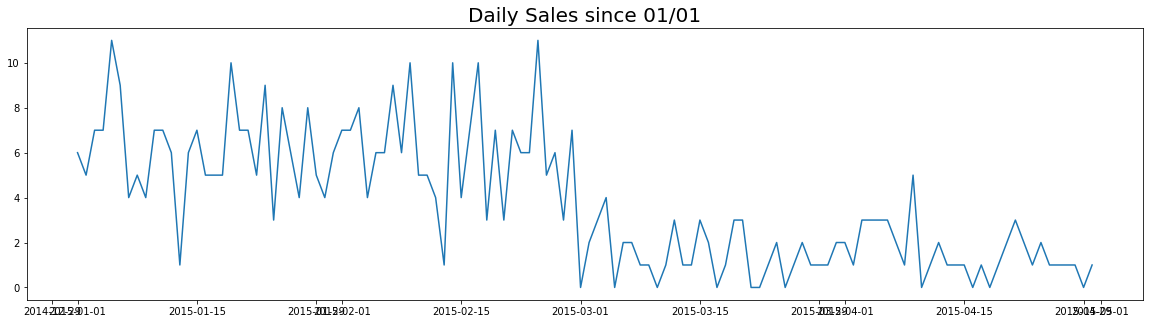

In [257]:
# master_data.groupby['cohort_month']('payment_confirmation_page').sum()
daily_sales =(pd.DataFrame(master_data.groupby('date')['payment_confirmation_page'].sum())).reset_index()
daily_sales.head()
fig= plt.figure(figsize=(20,5))

plt.title('Daily Sales since 01/01', fontsize=20)
plt.plot(daily_sales.date, daily_sales.payment_confirmation_page)



In [266]:


stage_conversion =(pd.DataFrame(master_data.groupby('cohort_month')['homepage'].sum())).reset_index()


,cohort_month
0,January
1,February
2,March
3,April


In [272]:
funnel_stages = ['homepage', 'search_page','payment_page', 'payment_confirmation_page']
monthly_conversion =pd.DataFrame(['January', 'February', 'March', 'April'],columns = ['cohort_month'])

for stage in funnel_stages: 
    stage_conversion =(pd.DataFrame(master_data.groupby('cohort_month')[stage].sum())).reset_index()
    monthly_conversion=pd.merge(monthly_conversion, stage_conversion, how = 'left', on='cohort_month')
    
monthly_conversion
monthly_conversion['stage1/2']= (monthly_conversion['search_page']/monthly_conversion['homepage'])*100
monthly_conversion['stage2/3']= (monthly_conversion['payment_page']/monthly_conversion['search_page'])*100
monthly_conversion['stage3/4']= (monthly_conversion['payment_confirmation_page']/monthly_conversion['payment_page'])*100

monthly_conversion['stage1/3']= (monthly_conversion['payment_page']/monthly_conversion['homepage'])*100
monthly_conversion['stage1/4']= (monthly_conversion['payment_confirmation_page']/monthly_conversion['homepage'])*100

monthly_conversion

,cohort_month,homepage,search_page,payment_page,payment_confirmation_page,stage1/2,stage2/3,stage3/4,stage1/3,stage1/4
0,January,22600,13554,2390,189,59.973451,17.633171,7.907950,10.575221,0.836283
1,February,22600,13687,2412,173,60.561947,17.622562,7.172471,10.672566,0.765487
2,March,22600,8879,631,44,39.287611,7.106656,6.973059,2.792035,0.194690
3,April,22600,9080,597,46,40.176991,6.574890,7.705193,2.641593,0.203540


# Funnel Analysis

In [136]:
# funnel_breakdown

master_data.columns

count_stage = []
for page in funnel_stages: 
    x = len(master_data[master_data[page]==1])
    count_stage.append(x)
    
# funnel_breakdown = dict(zip(count_stage, funnel_stages))   

## Needs to be a dict in this way 

funnel_breakdown = dict(
    number= count_stage,
    stage=funnel_stages)

# fig = px.funnel(funnel_breakdown, x='number', y='stage')
# fig.show()

fig = go.Figure(go.Funnel(
    y = funnel_stages,
    x = count_stage,
    textposition = "inside",
    textinfo = "value+percent initial"))

fig.show()


## Desktop v Mobile Conversion
* https://plotly.com/python/funnel-charts/ 

In [137]:
fig = go.Figure()

for i in ['Desktop', 'Mobile']: 
    count_stage = []
    for page in funnel_stages: 
            x = len(master_data[(master_data[page]==1) & (master_data['device'] == i)])
            count_stage.append(x)
    
    fig.add_trace(go.Funnel(
        name = i,
        y = funnel_stages,
        x = count_stage,
        textinfo = "value+percent initial"))
    
fig.show()
    

## Gender Conversion 

In [84]:
fig = go.Figure()

for i in ['Male', 'Female']: 
    count_stage = []
    for page in funnel_stages: 
            x = len(master_data[(master_data[page]==1) & (master_data['sex'] == i)])
            count_stage.append(x)
    
    fig.add_trace(go.Funnel(
        name = i,
        y = funnel_stages,
        x = count_stage,
        textinfo = "value+percent initial"))
    
fig.show()
    

## Cohort Conversion 

In [115]:
master_data.head(2)

fig = go.Figure()

for i in ['January', 'February', 'March', 'April']: 
    count_stage = []
    for page in funnel_stages: 
            x = len(master_data[(master_data[page]==1) & (master_data['cohort_month'] == i)])
            count_stage.append(x)
    
    fig.add_trace(go.Funnel(
        name = i,
        y = funnel_stages,
        x = count_stage,
        textinfo = "value+percent initial"))
    
fig.show()
    

## Review desktop again by month 

In [274]:
master_data.head(2)

fig = go.Figure()

for i in ['January', 'February', 'March', 'April']: 
    count_stage = []
    for page in funnel_stages: 
            x = len(master_data[(master_data[page]==1) & (master_data['cohort_month'] == i) 
                                & (master_data.device == 'Mobile')])
            count_stage.append(x)
    
    fig.add_trace(go.Funnel(
        name = i,
        y = funnel_stages,
        x = count_stage,
        textinfo = "value+percent initial"))    
fig.show()
    

In [118]:
master_data.head(2)

fig = go.Figure()

for i in ['January', 'February', 'March', 'April']: 
    count_stage = []
    for page in funnel_stages: 
            x = len(master_data[(master_data[page]==1) & (master_data['cohort_month'] == i) 
                                & (master_data.device == 'Mobile')])
            count_stage.append(x)
    
    fig.add_trace(go.Funnel(
        name = i,
        y = funnel_stages,
        x = count_stage,
        textinfo = "value+percent initial"))    
fig.show()
    

In [156]:
x = 'test'

str(x + 'pct')

'testpct'

In [168]:
master_data[master_data.iloc[:,1] == '2015-02-28'] == True

,user_id,date,device,sex,homepage,search_page,payment_page,payment_confirmation_page,cohort_month
0,False,False,False,False,True,False,False,False,False
48,False,False,False,False,True,True,False,False,False
218,False,False,False,False,True,True,False,False,False
299,False,False,False,False,True,True,True,False,False
320,False,False,False,False,True,True,False,False,False
...,...,...,...,...,...,...,...,...,...
90191,False,False,False,False,True,True,False,False,False
90201,False,False,False,False,True,True,False,False,False
90236,False,False,False,False,True,True,False,False,False
90285,False,False,False,False,True,False,False,False,False


In [213]:
dates_conversion

,date
0,2015-01-01
1,2015-01-02
2,2015-01-03
3,2015-01-04
4,2015-01-05
...,...
115,2015-04-26
116,2015-04-27
117,2015-04-28
118,2015-04-29


In [224]:
dates_conversion = pd.DataFrame(sorted(master_data.date.unique()), columns = ['date'])


for page in funnel_stages: 
    date_df=master_data.groupby(['date', page]).size().reset_index(name=str(page + '_count'))
    date_df=date_df[date_df[page] ==1]
    date_df.drop(columns=[page], inplace=True)
    dates_conversion = pd.merge(dates_conversion, date_df, how='left', on='date')
    
dates_conversion['stage1/2'] = (dates_conversion['search_page_count']/ dates_conversion['homepage_count'])*100
dates_conversion['stage2/3'] = (dates_conversion['payment_page_count']/dates_conversion['search_page_count'])*100
dates_conversion['stage3/4'] = (dates_conversion['payment_confirmation_page_count']/ dates_conversion['payment_page_count'])*100

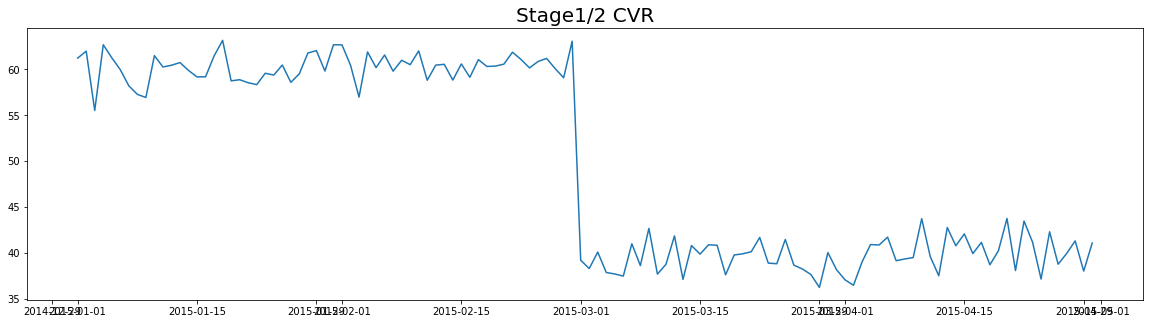

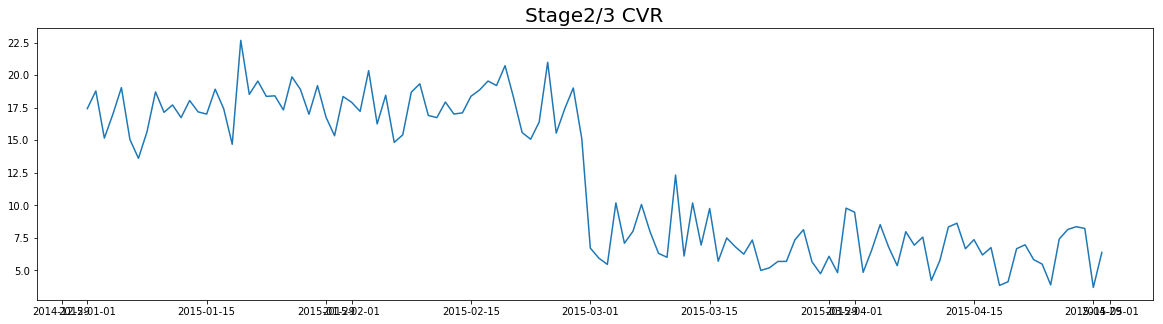

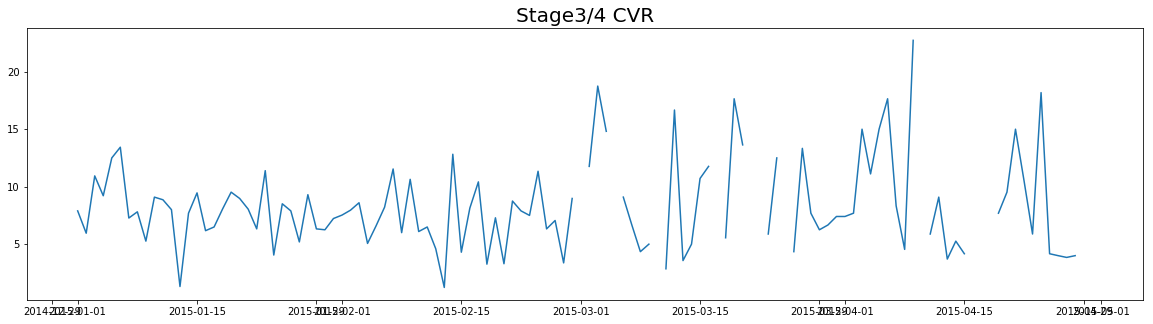

In [236]:
fig= plt.figure(figsize=(20,5))
plt.title('Stage1/2 CVR',fontsize = 20)
plt.plot(dates_conversion.date, dates_conversion['stage1/2'])

fig= plt.figure(figsize=(20,5))
plt.title('Stage2/3 CVR',fontsize = 20)
plt.plot(dates_conversion.date, dates_conversion['stage2/3'])

fig= plt.figure(figsize=(20,5))
plt.title('Stage3/4 CVR',fontsize = 20)
plt.plot(dates_conversion.date, dates_conversion['stage3/4'])


In [92]:
for page in funnel_stages: 


for d in sorted(master_data.date.unique()): 
        

2015-01-01T00:00:00.000000000
2015-01-02T00:00:00.000000000
2015-01-03T00:00:00.000000000
2015-01-04T00:00:00.000000000
2015-01-05T00:00:00.000000000
2015-01-06T00:00:00.000000000
2015-01-07T00:00:00.000000000
2015-01-08T00:00:00.000000000
2015-01-09T00:00:00.000000000
2015-01-10T00:00:00.000000000
2015-01-11T00:00:00.000000000
2015-01-12T00:00:00.000000000
2015-01-13T00:00:00.000000000
2015-01-14T00:00:00.000000000
2015-01-15T00:00:00.000000000
2015-01-16T00:00:00.000000000
2015-01-17T00:00:00.000000000
2015-01-18T00:00:00.000000000
2015-01-19T00:00:00.000000000
2015-01-20T00:00:00.000000000
2015-01-21T00:00:00.000000000
2015-01-22T00:00:00.000000000
2015-01-23T00:00:00.000000000
2015-01-24T00:00:00.000000000
2015-01-25T00:00:00.000000000
2015-01-26T00:00:00.000000000
2015-01-27T00:00:00.000000000
2015-01-28T00:00:00.000000000
2015-01-29T00:00:00.000000000
2015-01-30T00:00:00.000000000
2015-01-31T00:00:00.000000000
2015-02-01T00:00:00.000000000
2015-02-02T00:00:00.000000000
2015-02-03

In [89]:
table = pd.pivot_table(master_data,index=['homepage','search_page'])
table

user_id
homepage search_page               
1        0            498996.219292
         1            498423.147655